
# 🧪 Lab: Detecting **Data Drift** across Multiple Columns (Numeric & Categorical)
**No functions / no classes — step-by-step cells only**  
**Libraries**: `pandas`, `numpy`, `scipy`, `matplotlib`  

---

## What is Data Drift? / Data Drift คืออะไร (สรุปสองภาษา)
**English (EN):**  
Data Drift happens when the distribution of the **input data** your model receives in production changes from the data it was trained on — even if the input–output relationship is *supposedly* the same. Drift can silently degrade model performance.

**ภาษาไทย (TH):**  
**Data Drift (การเปลี่ยนแปลงข้อมูล)** เกิดขึ้นเมื่อ **การกระจายของข้อมูลนำเข้า** ที่โมเดลได้รับในระบบจริง (production) **เปลี่ยนไป** จากข้อมูลที่ใช้ฝึก แม้ว่าความสัมพันธ์ระหว่างอินพุตและเอาต์พุตอาจยังเหมือนเดิมก็ตาม ส่งผลให้ความแม่นยำของโมเดล **ลดลง** โดยเฉพาะในระบบที่ข้อมูลอัปเดตแบบเรียลไทม์

### Common causes / สาเหตุที่พบบ่อย
- **Seasonality / Events**: e.g., Black Friday, New Year.  
  **ตามฤดูกาล/เหตุการณ์**: เช่น Black Friday
- **New data sources or sensors**: device upgrade shifts readings.  
  **เปลี่ยนแหล่งข้อมูล/อุปกรณ์**: เซ็นเซอร์รุ่นใหม่วัดค่าไวขึ้น
- **Sampling bias**: user population mix changes.  
  **Sampling bias**: กลุ่มผู้ใช้เปลี่ยน (เมือง → ชนบท)
- **Technical issues / format changes / noise**  
  **ปัญหาทางเทคนิค**: รูปแบบข้อมูลเปลี่ยน, สัญญาณรบกวน

### Real-world examples / ตัวอย่างจริง
- **Fraud detection**: offline → online purchase surge during COVID-19 → distribution shifts.  
- **Computer vision**: trained on daytime photos, used at night → lighting/color distribution shifts.  
- **Air quality IoT**: sensor upgrade → values higher without real pollution change.  
- **Music recommender**: trained on US users, deployed in Asia → preference distribution changes.

### How to detect / วิธีตรวจจับ
- **Descriptive statistics** (mean, variance, skewness)  
- **Statistical tests**:  
  - **KS test** for **numeric** features  
  - **Chi-Square test** for **categorical** features  
- **Visualization**: histograms, boxplots, bar charts  
- **Monitoring**: schedule regular checks; alert on thresholds

### How to fix / วิธีแก้ไข
- Retrain or fine-tune with fresh data  
- Normalization & feature engineering  
- Ensemble / robust models  
- Continuous monitoring & alerts



## 🎯 Lab Goals / เป้าหมายของแลบ
1) Create **reference** (training-like) and **current** (production-like) datasets with **numeric** and **categorical** columns.  
2) Compare distributions via **visualizations** and **statistical tests** (KS for numeric, Chi-Square for categorical).  
3) Summarize results in a **Drift Report** (per-column): statistic, p-value, decision, and PSI (Population Stability Index).  
4) Do everything **step-by-step** with **no functions/classes** so students can follow and modify easily.

> 💡 You can re-run cells after tweaking parameters (e.g., means, category shares) to see how drift flags change.


In [1]:

# STEP 0 — Setup: imports & reproducibility
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

np.random.seed(42)

pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 100)

print("Lib versions:")
print("numpy:", np.__version__)
print("pandas:", pd.__version__)
print("matplotlib:", plt.matplotlib.__version__)
print("scipy:", stats.__version__ if hasattr(stats, "__version__") else "scipy.stats")


Lib versions:
numpy: 2.3.3
pandas: 2.3.2
matplotlib: 3.10.6
scipy: scipy.stats



## STEP 1 — Create Reference vs Current Datasets  
**Reference** ≈ like training data.  
**Current** ≈ like production data *after some drift*.  





## 2) Feature-by-Feature Drift

### 2.1 Numeric Features
| Feature  | Reference (Train-like)                       | Current (Prod-like)                              | Drift Type                         | Suggested Test(s)           | Likely Impact |
|---|---|---|---|---|---|
| `age`    | Normal(μ≈35, σ≈10)                           | Normal(μ≈40, σ≈11)                               | **Mean shift** (+5), ↑variance     | **KS test**, **PSI**        | Models trained on younger users may underperform |
| `income` | Lognormal(mean=10.5, σ=0.5)                  | Lognormal(mean=10.7, σ=0.55)                     | **Center ↑ + variance ↑**          | **KS test**, **PSI**        | Spending/propensity estimates can be biased |
| `clicks` | Poisson(λ=5)                                 | Poisson(λ=3.8)                                   | **Rate decrease**                  | **KS test** (on values), **PSI** | Engagement models may over-predict |

> **KS test (intuition):** compares two continuous distributions.  
> **PSI (Population Stability Index):** quantifies magnitude of shift across bins.

---

### 2.2 Categorical Features
| Feature           | Reference Mix                                 | Current Mix                                   | Drift Type                       | Suggested Test(s)            | Likely Impact |
|---|---|---|---|---|---|
| `country`         | US 45%, TH 20%, JP 20%, IN 15%                 | US 25%, TH 40%, JP 20%, IN 15%                | **Regional mix shift**           | **Chi-Square**, **PSI**      | Behavior learned on US-heavy data won’t generalize |
| `device`          | mobile 55%, desktop 35%, tablet 10%            | mobile 70%, desktop 20%, tablet 10%           | **Device preference shift**      | **Chi-Square**, **PSI**      | Desktop-oriented patterns weaken |
| `signup_channel`  | ads 40%, organic 40%, social 20%               | ads 30%, organic 50%, social 20%              | **Acquisition mix shift**        | **Chi-Square**, **PSI**      | Attribution/ROI models may misfire |

> **Chi-Square (intuition):** tests whether two distributions over categories are the same.

---

### 2.3 Missingness Drift (NaN patterns)
| Column   | Reference Missing | Current Missing | Drift Type/Note | Detection |
|---|---:|---:|---|---|
| `age`    | 20 rows           | 35 rows         | **More missing now** | Compare null rates (%), control charts |
| `device` | 15 rows           | 5 rows          | **Less missing now**  | Compare null rates (%), proportion tests |

> **หมายเหตุ (TH):** รูปแบบ NaN ที่เปลี่ยนไปทำให้การทำ **imputation** แบบเดิมอาจไม่เหมาะสม และส่งผลต่อการเรียนรู้ของโมเดล

---

## 3) How to Detect (linking to notebook steps)

- **Descriptive statistics:** `df.describe()` for numeric; `value_counts(normalize=True)` for categorical
- **Visualizations:**  
  - Numeric → histograms, boxplots  
  - Categorical → bar charts of proportions (include a **“__MISSING__”** bucket for NaN)
- **Statistical tests:**  
  - **Numeric:** KS test (`scipy.stats.ks_2samp`)  
  - **Categorical:** Chi-Square (`scipy.stats.chi2_contingency`)  
- **PSI:** Compute for both numeric (binned) and categorical (category proportions)

> **PSI Guide:** `< 0.10` = No shift, `0.10–0.25` = Moderate, `> 0.25` = Large

---



In [16]:

# Create REFERENCE (train-like) data
n_ref = 1000

age_ref = np.random.normal(loc=35, scale=10, size=n_ref)            # numeric (continuous)
income_ref = np.random.lognormal(mean=10.5, sigma=0.5, size=n_ref)   # numeric (positive, skewed)
clicks_ref = np.random.poisson(lam=5, size=n_ref)                    # numeric (count)

countries = np.array(["US", "TH", "JP", "IN"])
country_ref = np.random.choice(countries, size=n_ref, p=[0.45, 0.20, 0.20, 0.15])

devices = np.array(["mobile", "desktop", "tablet"])
device_ref = np.random.choice(devices, size=n_ref, p=[0.55, 0.35, 0.10])

channels = np.array(["ads", "organic", "social"])
signup_ref = np.random.choice(channels, size=n_ref, p=[0.40, 0.40, 0.20])

ref = pd.DataFrame({
    "age": age_ref,
    "income": income_ref,
    "clicks": clicks_ref,
    "country": country_ref,
    "device": device_ref,
    "signup_channel": signup_ref,
})

# Inject a few missing values to mimic reality
ref.loc[np.random.choice(ref.index, size=20, replace=False), "age"] = np.nan
ref.loc[np.random.choice(ref.index, size=15, replace=False), "device"] = np.nan

ref


,age,income,clicks,country,device,signup_channel
0,25.860566,29612.255067,8,TH,desktop,organic
1,19.876968,26674.065282,2,JP,mobile,ads
2,40.548979,12411.752729,6,US,desktop,social
3,26.930737,24733.388831,6,JP,mobile,organic
4,25.756429,41174.366800,6,US,mobile,organic
...,...,...,...,...,...,...
995,43.818415,61040.786926,6,TH,desktop,organic
996,38.908393,53934.481197,6,JP,desktop,social
997,24.521390,45399.591371,6,JP,mobile,social
998,31.235505,45053.447150,5,US,tablet,organic


In [17]:

# Create CURRENT (prod-like) data with DRIFT
n_cur = 1000

# Numeric drifts: older users on average; higher incomes; fewer clicks
age_cur = np.random.normal(loc=40, scale=11, size=n_cur)             # mean +5, slightly wider
income_cur = np.random.lognormal(mean=10.7, sigma=0.55, size=n_cur)  # higher mean & variance
clicks_cur = np.random.poisson(lam=3.8, size=n_cur)                  # fewer clicks on average

# Categorical drifts: regional shift; more mobile; channel mix changes
country_cur = np.random.choice(countries, size=n_cur, p=[0.25, 0.40, 0.20, 0.15])
device_cur = np.random.choice(devices, size=n_cur, p=[0.70, 0.20, 0.10])
signup_cur = np.random.choice(channels, size=n_cur, p=[0.30, 0.50, 0.20])

cur = pd.DataFrame({
    "age": age_cur,
    "income": income_cur,
    "clicks": clicks_cur,
    "country": country_cur,
    "device": device_cur,
    "signup_channel": signup_cur,
})

# Missingness patterns can also drift
cur.loc[np.random.choice(cur.index, size=35, replace=False), "age"] = np.nan
cur.loc[np.random.choice(cur.index, size=5, replace=False), "device"] = np.nan

cur


,age,income,clicks,country,device,signup_channel
0,51.023492,11997.520213,4,TH,mobile,ads
1,42.658307,28518.674568,5,US,mobile,ads
2,38.749965,41877.849824,3,TH,mobile,organic
3,44.915210,54353.938758,1,JP,mobile,organic
4,14.944640,42012.999828,2,JP,mobile,social
...,...,...,...,...,...,...
995,38.402352,64134.916065,3,JP,mobile,social
996,52.461692,18642.597709,4,IN,mobile,ads
997,35.668015,37376.674983,2,US,desktop,ads
998,54.667283,49300.805876,5,US,mobile,social


In [18]:
print("Reference shape:", ref.shape)
print("Current shape:  ", cur.shape)


Reference shape: (1000, 6)
Current shape:   (1000, 6)


In [20]:
print("\nReference info:")
ref.info()



Reference info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             980 non-null    float64
 1   income          1000 non-null   float64
 2   clicks          1000 non-null   int64  
 3   country         1000 non-null   object 
 4   device          985 non-null    object 
 5   signup_channel  1000 non-null   object 
dtypes: float64(2), int64(1), object(3)
memory usage: 47.0+ KB


In [21]:

print("\nCurrent info:")
cur.info()



Current info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             965 non-null    float64
 1   income          1000 non-null   float64
 2   clicks          1000 non-null   int64  
 3   country         1000 non-null   object 
 4   device          995 non-null    object 
 5   signup_channel  1000 non-null   object 
dtypes: float64(2), int64(1), object(3)
memory usage: 47.0+ KB



## STEP 2 — Descriptive Statistics (สถิติเบื้องต้น)
Compare numeric summaries and category proportions to get an initial sense of drift.


In [5]:

# Numeric summaries
numeric_cols = ref.select_dtypes(include=[np.number]).columns.tolist()
print("Numeric columns:", numeric_cols)

desc_ref = ref[numeric_cols].describe().T
desc_cur = cur[numeric_cols].describe().T

print("\nReference numeric describe():")
display(desc_ref)

print("\nCurrent numeric describe():")
display(desc_cur)


Numeric columns: ['age', 'income', 'clicks']

Reference numeric describe():


,count,mean,std,min,25%,50%,75%,max
age,980.0,35.231921,9.808661,2.587327,28.524097,35.276021,41.504987,73.527315
income,1000.0,42562.569503,22316.493179,8348.237207,26819.359082,37479.103259,52283.790931,179253.051840
clicks,1000.0,4.918000,2.092284,0.000000,3.000000,5.000000,6.000000,12.000000



Current numeric describe():


,count,mean,std,min,25%,50%,75%,max
age,965.0,39.754512,10.695072,4.441780,32.465042,39.672158,47.028525,72.055201
income,1000.0,51789.398711,31193.610990,6928.727788,31417.851199,44165.777904,63270.739166,284296.370954
clicks,1000.0,3.903000,2.017340,0.000000,2.000000,4.000000,5.000000,13.000000


In [6]:

# Categorical proportion tables
categorical_cols = ref.select_dtypes(exclude=[np.number]).columns.tolist()
print("Categorical columns:", categorical_cols)

for c in categorical_cols:
    print(f"\n== Column: {c} ==")
    print("Reference proportions:")
    display((ref[c].value_counts(normalize=True, dropna=False)*100).round(2).rename("ref_%"))
    print("Current proportions:")
    display((cur[c].value_counts(normalize=True, dropna=False)*100).round(2).rename("cur_%"))


Categorical columns: ['country', 'device', 'signup_channel']

== Column: country ==
Reference proportions:


country
US    45.2
TH    21.2
JP    19.6
IN    14.0
Name: ref_%, dtype: float64

Current proportions:


country
TH    40.6
US    23.7
JP    19.4
IN    16.3
Name: cur_%, dtype: float64


== Column: device ==
Reference proportions:


device
mobile     55.7
desktop    32.9
tablet      9.9
NaN         1.5
Name: ref_%, dtype: float64

Current proportions:


device
mobile     66.9
desktop    21.6
tablet     11.0
NaN         0.5
Name: cur_%, dtype: float64


== Column: signup_channel ==
Reference proportions:


signup_channel
organic    41.6
ads        38.2
social     20.2
Name: ref_%, dtype: float64

Current proportions:


signup_channel
organic    52.6
ads        27.8
social     19.6
Name: cur_%, dtype: float64


## STEP 3 — Visualize Distributions (แสดงการกระจายข้อมูล)
- **Numeric**: overlay histograms + side-by-side boxplots.  
- **Categorical**: bar charts of category proportions.  
> Each chart uses **matplotlib** (no seaborn), one figure per chart, default colors.


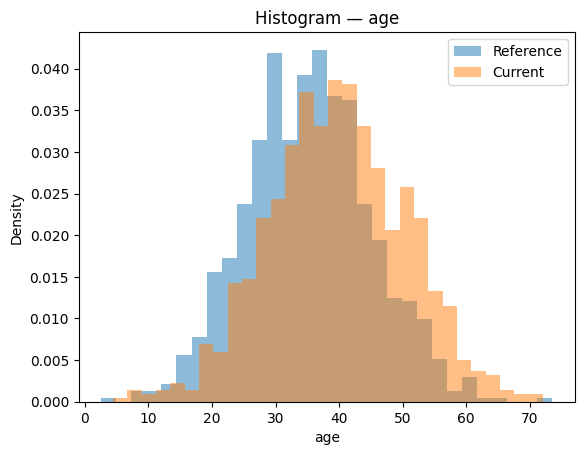

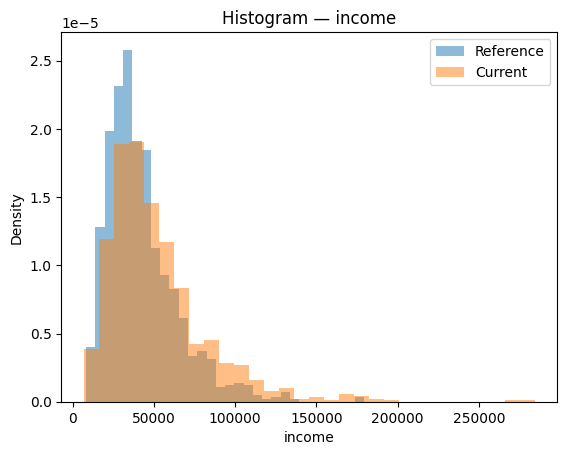

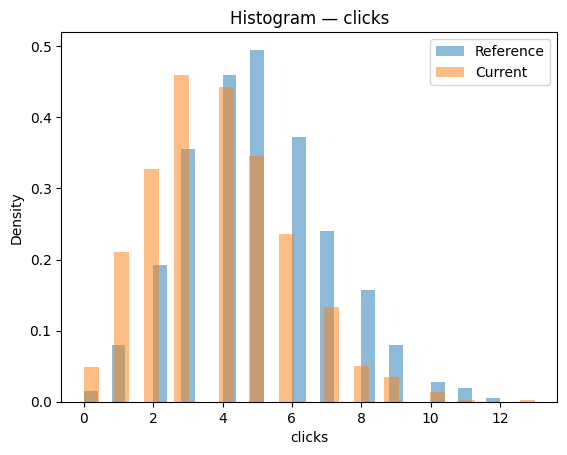

In [7]:

# Histograms (numeric)
for col in numeric_cols:
    plt.figure()
    plt.hist(ref[col].dropna(), bins=30, alpha=0.5, density=True, label="Reference")
    plt.hist(cur[col].dropna(), bins=30, alpha=0.5, density=True, label="Current")
    plt.title(f"Histogram — {col}")
    plt.xlabel(col)
    plt.ylabel("Density")
    plt.legend()
    plt.show()


/tmp/ipykernel_2332/1666399914.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([ref[col].dropna(), cur[col].dropna()], labels=["Reference", "Current"])


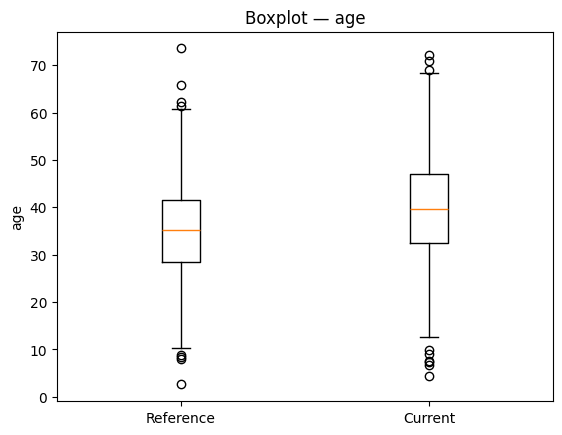

/tmp/ipykernel_2332/1666399914.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([ref[col].dropna(), cur[col].dropna()], labels=["Reference", "Current"])


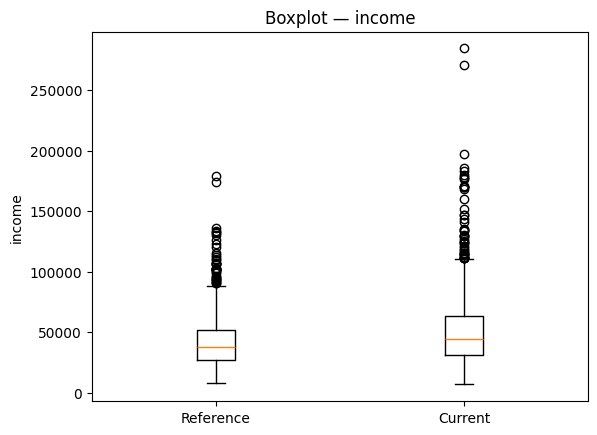

/tmp/ipykernel_2332/1666399914.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([ref[col].dropna(), cur[col].dropna()], labels=["Reference", "Current"])


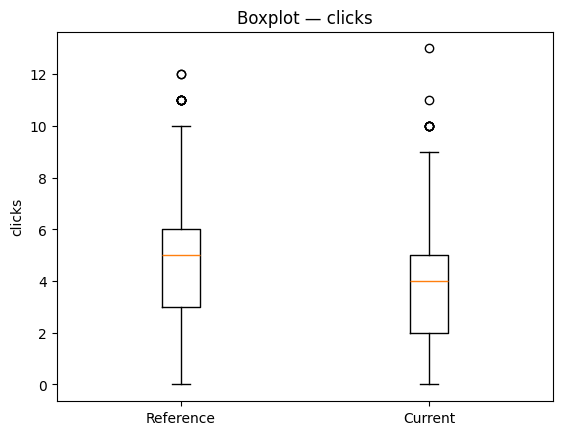

In [8]:

# Boxplots (numeric)
for col in numeric_cols:
    plt.figure()
    plt.boxplot([ref[col].dropna(), cur[col].dropna()], labels=["Reference", "Current"])
    plt.title(f"Boxplot — {col}")
    plt.ylabel(col)
    plt.show()


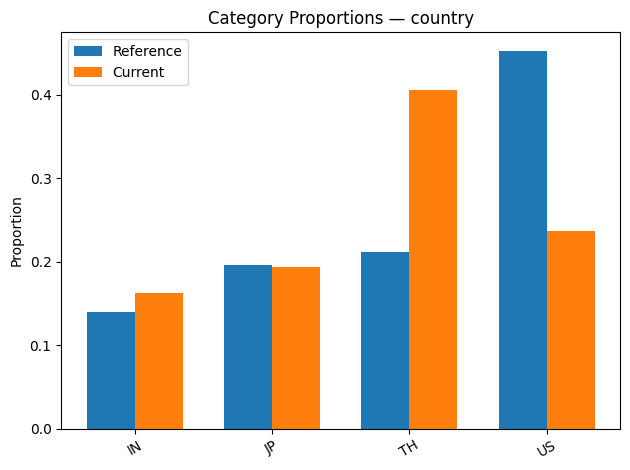

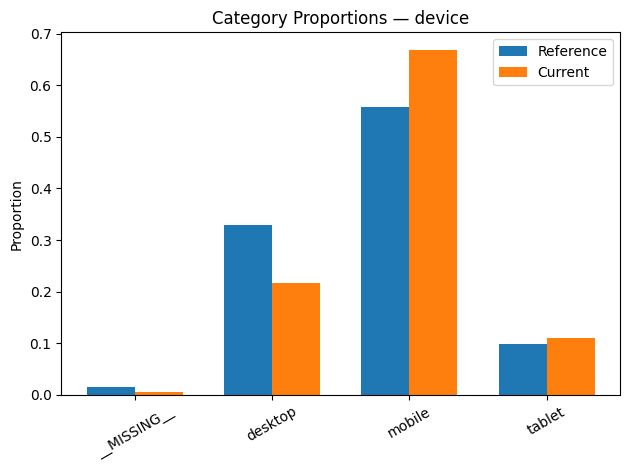

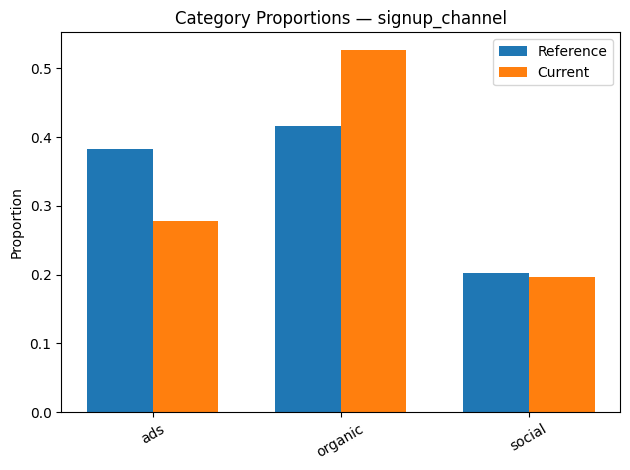

In [15]:
# Bar charts (categorical) — FIXED for mixed types / NaN
for col in categorical_cols:
    plt.figure()

    # Convert to object and replace missing with a string token
    ref_cat = ref[col].astype("object")
    cur_cat = cur[col].astype("object")
    ref_cat = ref_cat.where(pd.notna(ref_cat), "__MISSING__")
    cur_cat = cur_cat.where(pd.notna(cur_cat), "__MISSING__")

    # Unified category set, sorted by string rep to avoid type-compare errors
    cats = sorted(set(ref_cat.unique()) | set(cur_cat.unique()), key=lambda x: str(x))

    # Proportions per category
    ref_props = [(ref_cat == k).mean() for k in cats]
    cur_props = [(cur_cat == k).mean() for k in cats]

    x = np.arange(len(cats))
    width = 0.35
    plt.bar(x - width/2, ref_props, width, label="Reference")
    plt.bar(x + width/2, cur_props, width, label="Current")
    plt.xticks(x, cats, rotation=30)
    plt.ylabel("Proportion")
    plt.title(f"Category Proportions — {col}")
    plt.legend()
    plt.tight_layout()
    plt.show()



## STEP 4 — Statistical Tests for **Numeric** Columns  
**Kolmogorov–Smirnov (KS) test** compares two continuous distributions.  
- **Null (H₀)**: both samples come from the same distribution.  
- **If p-value < α (e.g., 0.05)** → **Reject H₀** → **Drift detected**.

We also compute **PSI (Population Stability Index)** to quantify magnitude of shift:
\[
\text{PSI} = \sum_i (p_i^{ref} - p_i^{cur}) \cdot \ln\left(\frac{p_i^{ref}}{p_i^{cur}}\right)
\]
Guideline: <0.1 (no shift), 0.1–0.25 (moderate), >0.25 (large).


In [10]:

alpha = 0.05
results_rows = []

# KS + PSI for numeric
for col in numeric_cols:
    ref_vals = ref[col].dropna().values
    cur_vals = cur[col].dropna().values

    ks_stat, ks_p = stats.ks_2samp(ref_vals, cur_vals, alternative="two-sided", mode="auto")

    # PSI via reference quantile bins (10 bins)
    quantiles = np.linspace(0, 1, 11)
    q = np.quantile(ref_vals, quantiles)
    # ensure unique bin edges
    edges = np.unique(q)
    if edges.shape[0] < 2:
        psi = np.nan
    else:
        ref_counts, _ = np.histogram(ref_vals, bins=edges)
        cur_counts, _ = np.histogram(cur_vals, bins=edges)
        ref_perc = ref_counts / max(1, ref_counts.sum())
        cur_perc = cur_counts / max(1, cur_counts.sum())
        eps = 1e-6
        ref_perc = np.clip(ref_perc, eps, None)
        cur_perc = np.clip(cur_perc, eps, None)
        psi = np.sum((ref_perc - cur_perc) * np.log(ref_perc / cur_perc))

    results_rows.append({
        "column": col,
        "type": "numeric",
        "test": "KS",
        "statistic": ks_stat,
        "p_value": ks_p,
        "alpha": alpha,
        "drift_detected_p<alpha": bool(ks_p < alpha),
        "psi": psi,
    })

pd.DataFrame(results_rows)


,column,type,test,statistic,p_value,alpha,drift_detected_p<alpha,psi
0,age,numeric,KS,0.191842,3.890785e-16,0.05,True,0.208967
1,income,numeric,KS,0.139000,7.709567e-09,0.05,True,0.099757
2,clicks,numeric,KS,0.204000,1.285775e-18,0.05,True,0.259560



## STEP 5 — Statistical Tests for **Categorical** Columns  
**Chi-Square test** on a 2×K contingency table (Reference vs Current counts per category).  
- **Null (H₀)**: the two distributions over categories are the same.  
- **If p-value < α** → **Drift detected**.

We also compute **PSI** using category proportions.


In [11]:

for col in categorical_cols:
    ref_counts = ref[col].astype("object").value_counts()
    cur_counts = cur[col].astype("object").value_counts()
    cats = sorted(set(ref_counts.index) | set(cur_counts.index))

    ref_freq = np.array([ref_counts.get(k, 0) for k in cats])
    cur_freq = np.array([cur_counts.get(k, 0) for k in cats])

    contingency = np.vstack([ref_freq, cur_freq])
    chi2, p, dof, expected = stats.chi2_contingency(contingency, correction=False)

    # PSI for categorical
    ref_perc = ref_freq / ref_freq.sum() if ref_freq.sum() > 0 else np.zeros_like(ref_freq, dtype=float)
    cur_perc = cur_freq / cur_freq.sum() if cur_freq.sum() > 0 else np.zeros_like(cur_freq, dtype=float)
    eps = 1e-6
    ref_perc = np.clip(ref_perc, eps, None)
    cur_perc = np.clip(cur_perc, eps, None)
    psi = np.sum((ref_perc - cur_perc) * np.log(ref_perc / cur_perc))

    results_rows.append({
        "column": col,
        "type": "categorical",
        "test": "Chi-Square",
        "statistic": chi2,
        "p_value": p,
        "alpha": alpha,
        "drift_detected_p<alpha": bool(p < alpha),
        "psi": psi,
    })

results = pd.DataFrame(results_rows)
results


,column,type,test,statistic,p_value,alpha,drift_detected_p<alpha,psi
0,age,numeric,KS,0.191842,3.890785e-16,0.05,True,0.208967
1,income,numeric,KS,0.139000,7.709567e-09,0.05,True,0.099757
2,clicks,numeric,KS,0.204000,1.285775e-18,0.05,True,0.259560
3,country,categorical,Chi-Square,129.745793,6.135574e-28,0.05,True,0.268383
4,device,categorical,Chi-Square,34.190320,3.764145e-08,0.05,True,0.069840
5,signup_channel,categorical,Chi-Square,29.323342,4.290592e-07,0.05,True,0.059040



## STEP 6 — Drift Report (สรุปผลการตรวจ)
We combine numeric + categorical test outcomes and add a PSI interpretation bucket.

**PSI guide**:  
- `< 0.10` → **No shift**  
- `0.10–0.25` → **Moderate**  
- `> 0.25` → **Large**


In [12]:

psi_bucket_labels = []
for v in results["psi"]:
    if pd.isna(v):
        psi_bucket_labels.append("N/A")
    elif v < 0.10:
        psi_bucket_labels.append("No shift (<0.10)")
    elif v < 0.25:
        psi_bucket_labels.append("Moderate (0.10–0.25)")
    else:
        psi_bucket_labels.append("Large (>0.25)")

results["psi_bucket"] = psi_bucket_labels
results_sorted = results.sort_values(by=["drift_detected_p<alpha", "p_value"], ascending=[False, True]).reset_index(drop=True)
display(results_sorted)

# Save to CSV for sharing
results_sorted.to_csv("drift_report.csv", index=False)
print("Saved: drift_report.csv")


,column,type,test,statistic,p_value,alpha,drift_detected_p<alpha,psi,psi_bucket
0,country,categorical,Chi-Square,129.745793,6.135574e-28,0.05,True,0.268383,Large (>0.25)
1,clicks,numeric,KS,0.204000,1.285775e-18,0.05,True,0.259560,Large (>0.25)
2,age,numeric,KS,0.191842,3.890785e-16,0.05,True,0.208967,Moderate (0.10–0.25)
3,income,numeric,KS,0.139000,7.709567e-09,0.05,True,0.099757,No shift (<0.10)
4,device,categorical,Chi-Square,34.190320,3.764145e-08,0.05,True,0.069840,No shift (<0.10)
5,signup_channel,categorical,Chi-Square,29.323342,4.290592e-07,0.05,True,0.059040,No shift (<0.10)


Saved: drift_report.csv



### Quick Highlights
Top features where **p < α** (flagged as drifted), ordered by p-value:


In [13]:

flagged = results_sorted[results_sorted["drift_detected_p<alpha"]]
display(flagged.sort_values("p_value").head(10))


,column,type,test,statistic,p_value,alpha,drift_detected_p<alpha,psi,psi_bucket
0,country,categorical,Chi-Square,129.745793,6.135574e-28,0.05,True,0.268383,Large (>0.25)
1,clicks,numeric,KS,0.204000,1.285775e-18,0.05,True,0.259560,Large (>0.25)
2,age,numeric,KS,0.191842,3.890785e-16,0.05,True,0.208967,Moderate (0.10–0.25)
3,income,numeric,KS,0.139000,7.709567e-09,0.05,True,0.099757,No shift (<0.10)
4,device,categorical,Chi-Square,34.190320,3.764145e-08,0.05,True,0.069840,No shift (<0.10)
5,signup_channel,categorical,Chi-Square,29.323342,4.290592e-07,0.05,True,0.059040,No shift (<0.10)



## STEP 7 (Optional) — Streaming-style Check (KS over batches)
Simulate production arriving in batches and track KS p-values for one feature (e.g., `age`).  
Alert if p-value drops below α.


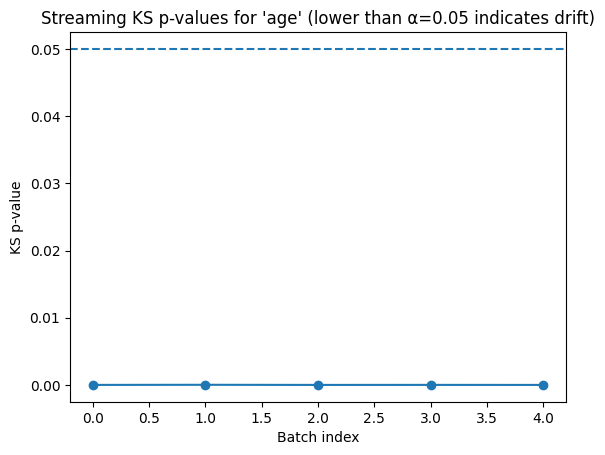

,batch_index,ks_p_value
0,0,2.975050e-06
1,1,1.945554e-05
2,2,1.942232e-07
3,3,5.831303e-06
4,4,7.363098e-08


In [14]:

batch_size = 200
pvals = []
feature = "age"

shuffled = cur.sample(frac=1.0, random_state=123).reset_index(drop=True)
for i in range(0, len(shuffled), batch_size):
    batch = shuffled.iloc[i:i+batch_size]
    a = ref[feature].dropna().values
    b = batch[feature].dropna().values
    if len(b) == 0:
        pvals.append(np.nan)
    else:
        s, p = stats.ks_2samp(a, b, alternative="two-sided", mode="auto")
        pvals.append(p)

plt.figure()
plt.plot(range(len(pvals)), pvals, marker="o")
plt.axhline(alpha, linestyle="--")
plt.title(f"Streaming KS p-values for '{feature}' (lower than α={alpha} indicates drift)")
plt.xlabel("Batch index")
plt.ylabel("KS p-value")
plt.show()

pd.DataFrame({"batch_index": list(range(len(pvals))), "ks_p_value": pvals})



## STEP 8 — Interpret & Act (ตีความและแนวทางแก้ไข)
- If **numeric KS p < α** or **categorical Chi-Square p < α**, we flag drift.  
- Use **PSI** to understand **how large** the shift is.  
- Consider **retraining**, **rebalancing**, **normalization**, or **feature engineering**.  
- For production: schedule this notebook (or equivalent scripts) to run regularly and alert on thresholds.

> **ข้อเสนอแนะ (TH):** หากตรวจพบ drift ควรรีบตรวจสอบและดำเนินการ เช่น ปรับปรุงข้อมูลฝึก, ทำ normalization ใหม่, retrain โมเดล และตั้งระบบแจ้งเตือน (alerting) ให้ทีม



## 📝 Exercises (ฝึกปฏิบัติ)
1) Change the drift parameters (e.g., increase `age` mean to 45, change `device` mix) and re-run.  
2) Add another numeric feature (e.g., `session_time`) and include it in all steps.  
3) Experiment with different **α** (0.01, 0.10) and observe false positives/negatives.  
4) Export `ref` and `cur` to CSV and try the tests in a separate notebook.


In [ ]:

# OPTIONAL: save the generated datasets
ref.to_csv("reference_dataset.csv", index=False)
cur.to_csv("current_dataset.csv", index=False)
print("Saved: reference_dataset.csv, current_dataset.csv")



> ✅ This lab intentionally uses **no functions** and **no classes** — so each step is explicit and easy to modify.
